In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal
import xarray as xr

from scipy.interpolate import interp1d
from scipy.signal import medfilt
from utils.data_reading.sound_data.station import StationsCatalog

In [14]:
#Choix des variables
station_name = "MAHY13" # Select the station
duration = 1 # Select the number of weeks from the start of the campaign
depth_choice = 1300 # Select a depth (m) for the hydrology data (e.g. the SOFAR canal)
#frequency -> il faudrait réussir à faire pareille que pour depth


/tmp/ipykernel_28790/4119957027.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_28790/4119957027.py:56: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


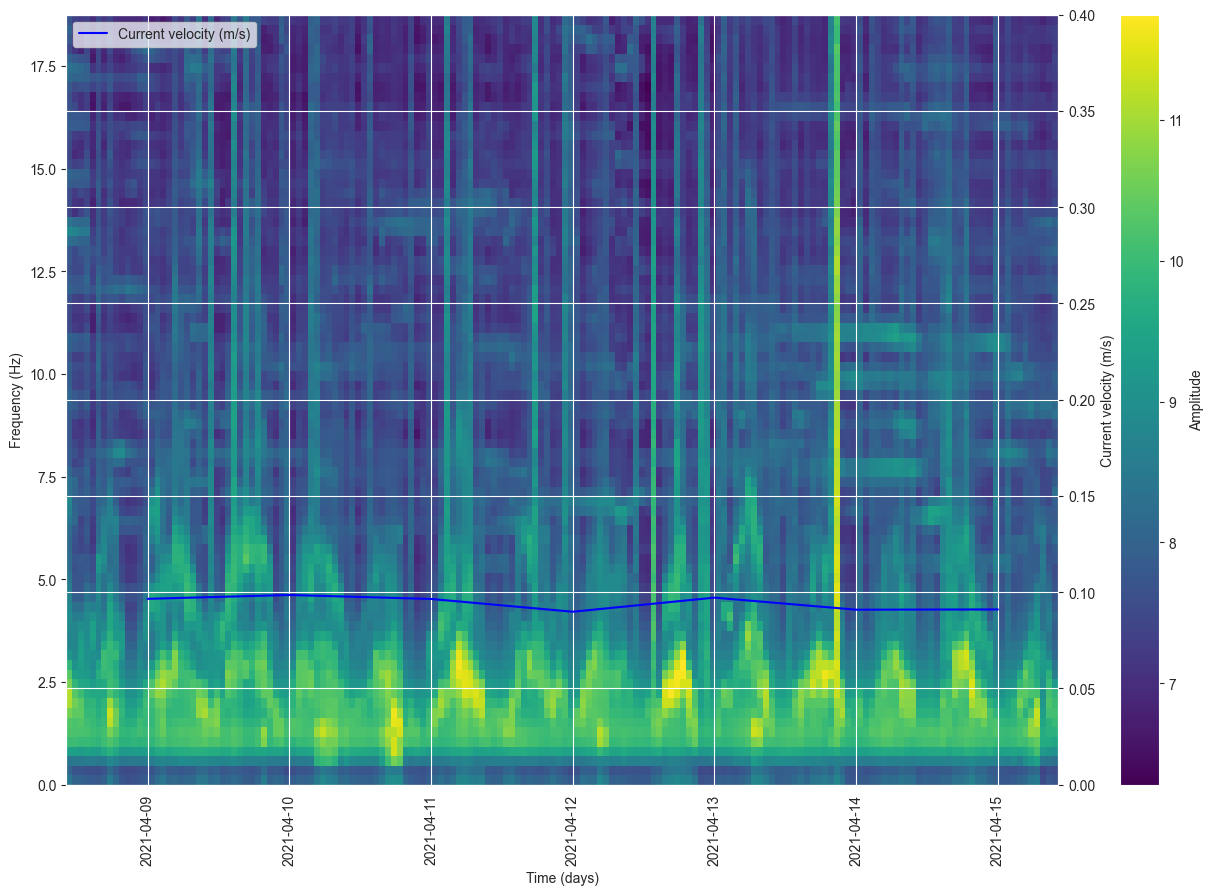

In [4]:
# Chargement des données
sys.path.append(".../.../.../.../toolbox/src")
mahy_data = pd.read_csv(".../.../.../.../MAHY.csv") # Path of a directory containing one MAHY station
mahy_data["date_start"] = pd.to_datetime(mahy_data["date_start"])
mahy_data["date_end"] = pd.to_datetime(mahy_data["date_end"])

catalog_path = ".../.../CORSAIR"  # Path of the hard drive containing MAHY data
station_metadata = mahy_data[mahy_data.station_name == station_name]
stations = StationsCatalog(catalog_path)
manager = stations.by_name(station_name)[0].get_manager()

hydro_data = xr.open_dataset(".../.../.../.../.../src/data_copernicus/hydro_3/h3_total_time.nc") # Path of a directory containing the hydrology data (copernicus) for the station selected

# LTAS & vitesse du courant
date_start = station_metadata.date_start.item()
date_end = station_metadata.date_start.item() + datetime.timedelta(weeks=duration)
step = datetime.timedelta(seconds=3600)  # on lit les données par segments d'une heure
n_steps = (date_end-date_start)/step  # nombre de segments à calculer, attention c'est un nombre flottant
n_steps = int(n_steps)  # on transforme le nombre flottant en nombre entier
psds = []  # liste des psd de chaque segment, on va la remplir segment par segment

for i in range(n_steps):
    segment_start = date_start + i * step  # début du ième segment
    segment_end = date_start + (i+1) * step   # fin du ième segment
    data = manager.get_segment(segment_start, segment_end)
    psd_frequencies, psd = signal.welch(data, fs=240, nperseg=1024)  # fs est la fréquence d’échantillonnage, nperseg le nombre de points utilisés par transformée de Fourier. La résolution fréquentielle du résultats est 240/256 Hz
    psds.append(psd)

fig, ax = plt.subplots(figsize = (16,10))
ax1 = ax.twinx() # Second axis for current speed
f_max = 80 # Maximum frequency on the spectrogram
sp = ax.imshow(np.log10(psds)[:,:f_max].T, aspect="auto", cmap="viridis", origin="lower", extent=(date_start, date_end, psd_frequencies[0], psd_frequencies[f_max]))

t = pd.to_datetime(hydro_data["time"])
mask = (t>date_start) & (t<date_end) # Filter to only select the campaign dates

# Color bar amplitudes
cbar = plt.colorbar(sp, ax=ax)
cbar.set_label("Amplitude")

depth_index = np.argmin(abs(hydro_data["depth"].data-depth_choice)) # Finds the index in the dataset corresponding to the depth chosen
uo = np.array(hydro_data["uo"][:,depth_index]).flatten()
vo = np.array(hydro_data["vo"][:,depth_index]).flatten()

velocity_magnitude = np.sqrt(uo**2+vo**2)[mask] # Current velocity
ax1.plot(t[mask], velocity_magnitude,label="Current velocity (m/s)", color="blue")
ax1.set_ylim(0,0.4) #limites ax1
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.grid(False, axis='y') # No grid for the frequency

ax.set_xlabel("Time (days)")
ax.set_ylabel("Frequency (Hz)")
ax1.set_ylabel("Current velocity (m/s)")
ax1.legend(loc="upper left")

fig.show()

/tmp/ipykernel_28790/3940755147.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_28790/3940755147.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


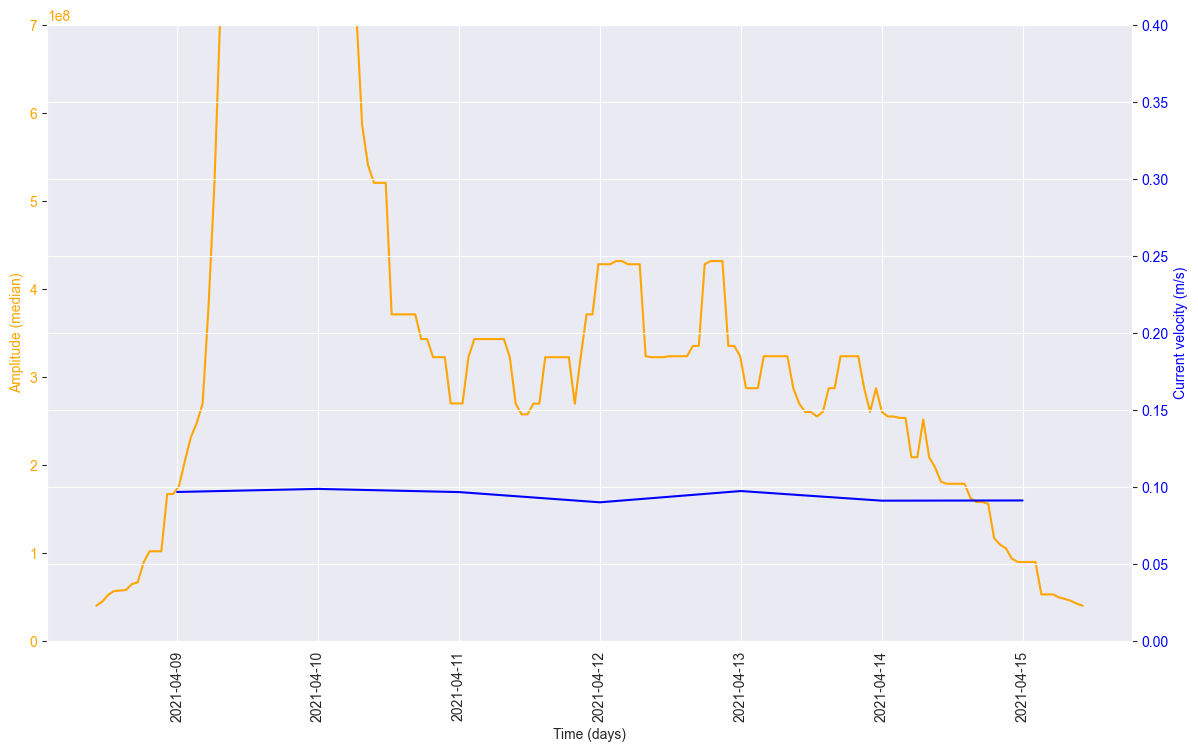

In [15]:
# Amplitude for a given freqeuncy & current velocity

frequency_index = 20 #choix d'une fréquence -> Pour l'instant ça ne correspond pas à une fréquence en Hz, mais à la position dans le tableau psd_frequencies
psds = np.array(psds)
amplitude = psds[:,frequency_index]
t = pd.to_datetime(hydro_data["time"])
mask = (t>date_start) & (t<date_end) # Only takes dates from the campaign

t_amplitude = pd.date_range(
    start=date_start,
    end=date_end,
    periods=n_steps)

amplitude_filt = medfilt(amplitude, kernel_size=51)

uo = np.array(hydro_data["uo"][:,depth_index]).flatten()
vo = np.array(hydro_data["vo"][:,depth_index]).flatten()

fig, ax = plt.subplots(figsize = (14,8))

ax.plot(t_amplitude, amplitude_filt, color="orange", label="Amplitude (median)")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Amplitude (median)", color="orange")
ax.tick_params(axis='y', labelcolor='orange')
#ax.plot(t_amplitude, amplitude, color="red", label="Amplitude")
ax.set_ylim(0,0.07e10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.grid(False, axis='y') # No grid for the amplitude

ax1 = ax.twinx()
ax1.plot(t[mask], velocity_magnitude, color="blue", label="Current velocity (m/s)")
ax1.set_ylim(0,0.4) #limites ax1
ax1.set_ylabel("Current velocity (m/s)", color="blue")
ax1.tick_params(axis='y', labelcolor='blue')

fig.show()

In [18]:
# Test the correlation between the amplitude and the current velocity

amplitude_filt = medfilt(amplitude, kernel_size=51)
f = interp1d(pd.to_numeric(t[mask]), velocity_magnitude, bounds_error=False)(pd.to_numeric(t_amplitude))
nanmask = ~np.isnan(f) # remove nan values
np.corrcoef(f[nanmask], amplitude_filt[nanmask])

array([[1.        , 0.66835462],
       [0.66835462, 1.        ]])